[SKL BaggingRegressor example](#SKL BaggingRegressor example)<br>

In [33]:
import os
import pprint as pp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 5)

Populating the interactive namespace from numpy and matplotlib


In [32]:
from IPython.display import Image
from urllib import urlretrieve


## SKL BaggingRegressor example <a id='SKL BaggingRegressor example'></a>

In [50]:
'''importing libraries'''
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

importing libraries


In [66]:
'''# Settings'''
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(0)

# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor()))]

print '\nBaggingRegressor(DecisionTreeRegressor())------------\n',BaggingRegressor(DecisionTreeRegressor())

n_estimators = len(estimators)


BaggingRegressor(DecisionTreeRegressor())------------
BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)


In [52]:
''' function we are trying to guess'''
def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

In [53]:
'''generate data set from target function'''
def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y

In [58]:
''' different data sets, that we are gonna compare the 
    bagged vs single estimator performance'''
X_train = []  
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)
    

# print '\nlen(X_train)------------\n',X_train
# print '\nlen(y_train)------------\n',len(y_train)


Tree: 0.0243 (error) = 0.0003 (bias^2)  + 0.0140 (var) + 0.0099 (noise)
Bagging(Tree): 0.0189 (error) = 0.0005 (bias^2)  + 0.0083 (var) + 0.0099 (noise)


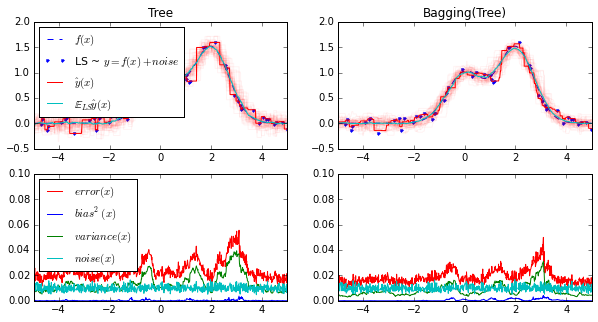

In [60]:
# create out of sample data to test the accuracy of our models
X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    
    ''' Compute predictions:
    ------------------------------------------------------------------------------'''
    y_predict = np.zeros((n_test, n_repeat))  # n_repeat = number of bags
    # initialize 0-array placeholders

    # create y predictions---------------------------------------
    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        # create models trained from in sample data
        y_predict[:, i] = estimator.predict(X_test) 
        # fill y_predict with predictions using out of sample data

    '''Bias^2 + Variance + Noise decomposition of the mean squared error
    ------------------------------------------------------------------------------'''
    y_error = np.zeros(n_test) # initialize error array

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))
    '''Plot figures
    ------------------------------------------------------------------------------
    subplot(211):
        produces a subaxes in a figure which represents the top plot (i.e. the
        first) in a 2 row by 1 column notional grid.'''

    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b--", label="$f(x)$")  
        # best calcs y using true function (no noise term)
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")  
        # calc 

    for i in range(n_repeat):  
        # n_repeat = 50 -> Number of iterations for computing expectations
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label="$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label="$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == 0:
        plt.legend(loc="upper left", prop={"size": 11})

    plt.subplot(2, n_estimators, n_estimators + n + 1) 
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == 0:
        plt.legend(loc="upper left", prop={"size": 11})

plt.show()

In [59]:
?subplot()

This example illustrates and compares the bias-variance decomposition of the expected mean squared error of a single estimator against a bagging ensemble.

In regression, the expected mean squared error of an estimator can be decomposed in terms of bias, variance and noise. '
* On average over datasets of the regression problem, the **<span style='background-color: lightgreen'>bias term</span> measures the average amount by which the predictions of the estimator differ from the predictions of the best possible estimator for the problem** (i.e., the Bayes model). 
* The **<span style='background-color: lightgreen'>variance term</span> measures the variability of the predictions of the estimator when fit over different instances LS of the problem**. Finally, the noise measures the irreducible part of the error which is due the variability in the data.

**The upper left** figure illustrates the <font color = 'red'>predictions</font> (in dark red) of a **single decision tree trained over a random dataset **LS (the blue dots) of a toy 1d regression problem. 
* It also illustrates the predictions (in light red) of other single decision trees trained over other (and different) randomly drawn instances LS of the problem. 

> Intuitively, the <span style='background-color: lightgreen'>variance term</span> here corresponds to the width of the beam of predictions (in light red) of the individual estimators. The larger the variance, the more sensitive are the predictions for x to small changes in the training set. 

> **The <span style='background-color: lightgreen'>bias term</span> corresponds to the difference between the <font color = 'cyan'>average prediction of the estimator</font> (in cyan) and the <font color = 'blue'>best possible model</font> (in dark blue)**. On this problem, we can thus observe that the bias is quite low (both the cyan and the blue curves are close to each other) while the variance is large (the red beam is rather wide).

**The lower left figure plots the pointwise decomposition of the expected mean squared error of a single decision tree.** It confirms that the bias term (in blue) is low while the variance is large (in green). It also illustrates the noise part of the error which, as expected, appears to be constant and around 0.01.

**The right figures** correspond to the same plots but using instead a bagging ensemble of decision trees. In both figures, we can observe that the bias term is larger than in the previous case. 
* In the upper right figure, the difference between the average prediction (in cyan) and the best possible model is larger (e.g., notice the offset around x=2). 

* In the lower right figure, the bias curve is also slightly higher than in the lower left figure. 
    * In terms of variance however, the beam of predictions is narrower, which suggests that the variance is lower. Indeed, as the lower right figure confirms, the <span style='background-color: lightgreen'>variance term</span> (in green) is lower than for single decision trees. 
* Overall, the bias- variance decomposition is therefore no longer the same. <font color = 'red'>The tradeoff is better for bagging: averaging several decision trees fit on bootstrap copies of the dataset slightly increases the bias term but allows for a larger reduction of the variance, which results in a lower overall mean squared error</font> (compare the red curves in the lower figures). 
    * The script output also confirms this intuition. The total error of the bagging ensemble is lower than the total error of a single decision tree, and this difference indeed mainly stems from a reduced variance.

# subplot examples

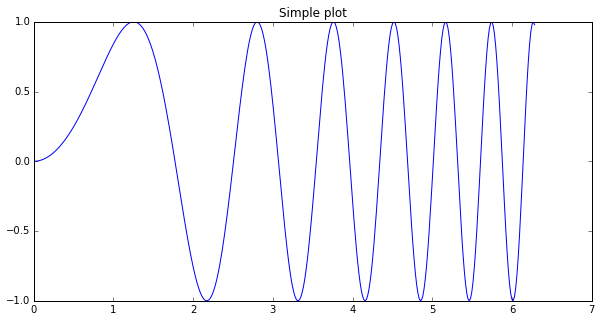

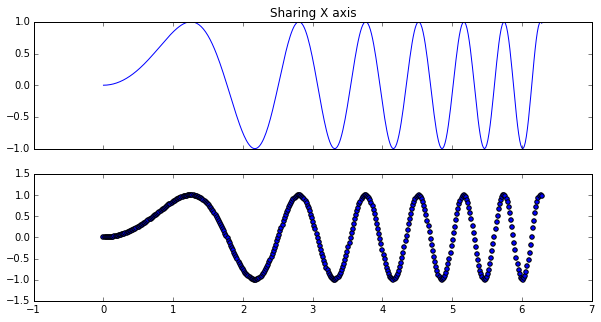

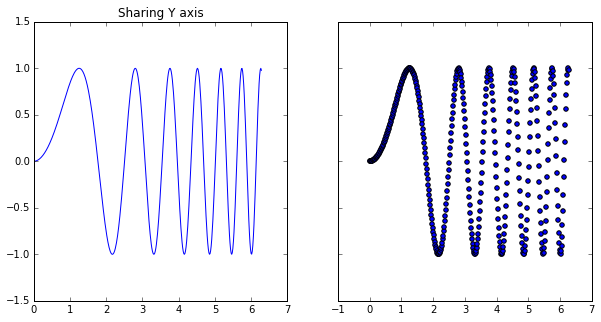

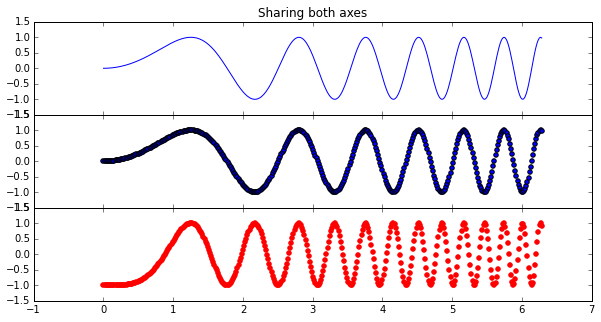

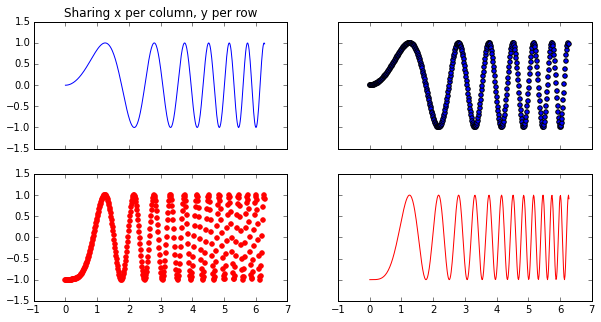

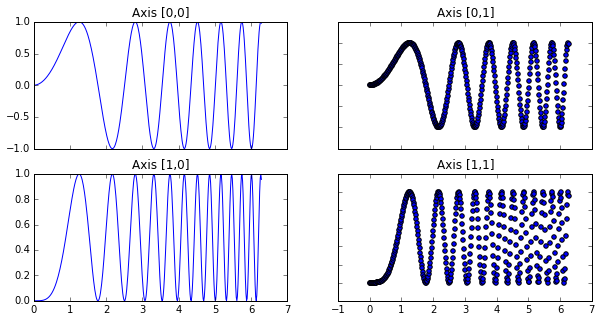

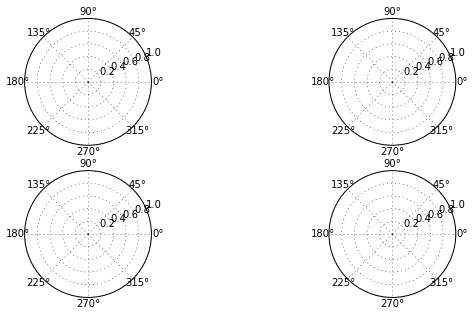

In [45]:
"""Examples illustrating the use of plt.subplots().

This function creates a figure and a grid of subplots with a single call, while
providing reasonable control over how the individual plots are created.  For
very refined tuning of subplot creation, you can still use add_subplot()
directly on a new figure.
"""

import matplotlib.pyplot as plt
import numpy as np

# Simple data to display in various forms
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

plt.close('all')

# Just a figure and one subplot
f, ax = plt.subplots()
ax.plot(x, y)
ax.set_title('Simple plot')

# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(x, y)
axarr[0].set_title('Sharing X axis')
axarr[1].scatter(x, y)

# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(x, y)
ax1.set_title('Sharing Y axis')
ax2.scatter(x, y)

# Three subplots sharing both x/y axes
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
ax1.plot(x, y)
ax1.set_title('Sharing both axes')
ax2.scatter(x, y)
ax3.scatter(x, 2 * y ** 2 - 1, color='r')
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

# row and column sharing
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
ax1.plot(x, y)
ax1.set_title('Sharing x per column, y per row')
ax2.scatter(x, y)
ax3.scatter(x, 2 * y ** 2 - 1, color='r')
ax4.plot(x, 2 * y ** 2 - 1, color='r')

# Four axes, returned as a 2-d array
f, axarr = plt.subplots(2, 2)
axarr[0, 0].plot(x, y)
axarr[0, 0].set_title('Axis [0,0]')
axarr[0, 1].scatter(x, y)
axarr[0, 1].set_title('Axis [0,1]')
axarr[1, 0].plot(x, y ** 2)
axarr[1, 0].set_title('Axis [1,0]')
axarr[1, 1].scatter(x, y ** 2)
axarr[1, 1].set_title('Axis [1,1]')
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)

# Four polar axes
plt.subplots(2, 2, subplot_kw=dict(projection='polar'))

plt.show()


# sbox <a id='sbox'></a>

# KNN rough

In [63]:
import numpy as np
from sklearn import neighbors, datasets     
 
# Load iris data from 'datasets module'
iris = datasets.load_iris()

#   Get data-records and record-labels in arrays X and y
X=iris.data
y=iris.target

# Create an instance of KNeighborsClassifier and then fit training data
clf = neighbors.KNeighborsClassifier()
clf.fit(X, y)

# Make class predictions for all observations in X
Z = clf.predict(X)

# Compare predicted class labels with actual class labels
accuracy=clf.score(X,y)
print ("Predicted model accuracy: "+ str(accuracy))
# Add a row of predicted classes to y-array for ease of comparison
A = np.vstack([y, Z])
print '\nA------------\n',A

Predicted model accuracy: 0.966666666667

A------------
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1
  1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 2 2 2 2
  2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2]]


In [71]:

import math
def euclideanDistance(instance1, instance2, length):
    distance = 0
    for x in range(length):
        distance += pow((instance1[x] - instance2[x]), 2)
        print '\ndistance------------\n',distance
    return math.sqrt(distance)


data1 = [1, 2, 2, 'a']
data2 = [4, 4, 4, 'b']
distance = euclideanDistance(data1, data2, 1)
print 'Distance: ' + repr(distance)



distance------------
9
Distance: 3.0
